In [6]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dirly import img_dirly

In [22]:
IMG_FILE = '/home/sharif/Downloads/4k/AXIS P1448-LE_2020-07-10_14_02_20_563.jpg'

In [23]:
def show(img):
    plt.figure(figsize = (15,10))
    plt.imshow(img)

(720, 1280, 3)


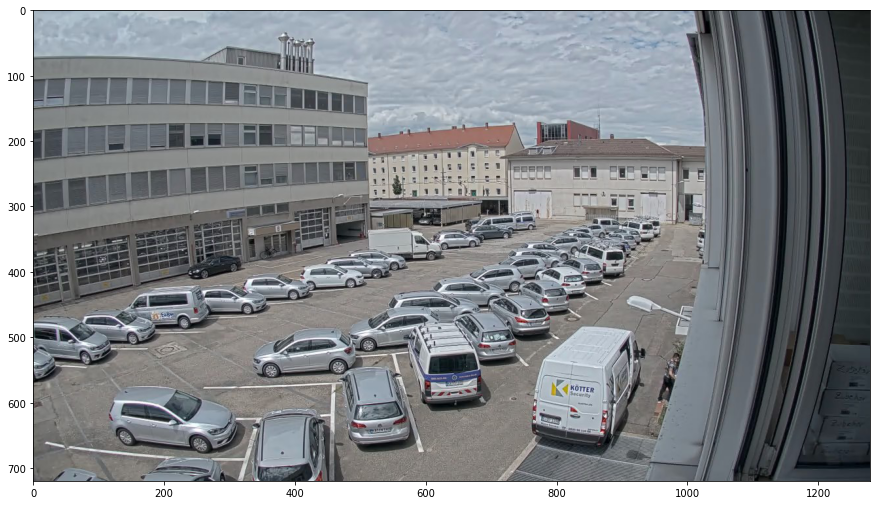

In [24]:
img = Image.open(IMG_FILE)#.resize((850,1020))
img = np.array(img)
print(img.shape)
show(img)

In [25]:
img.shape

(720, 1280, 3)

(500, 1280, 3)
(220, 1280, 3)


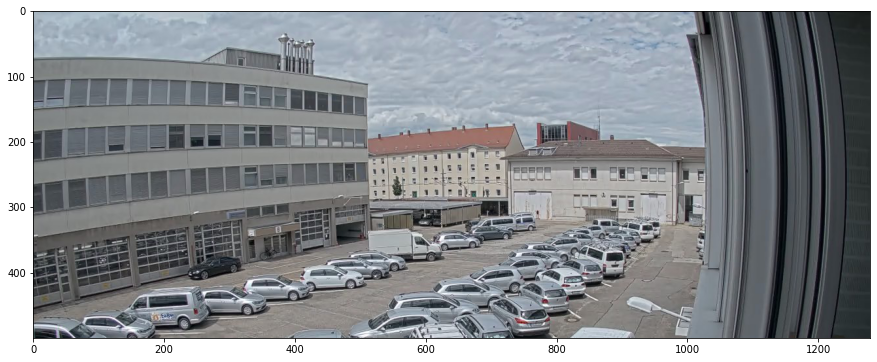

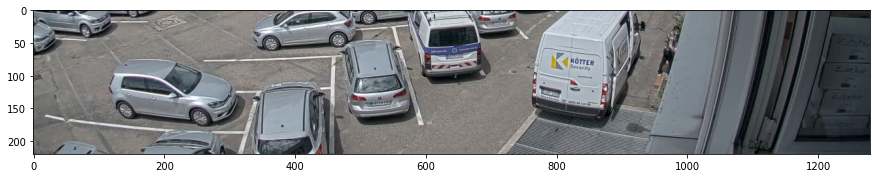

In [26]:
# top half
h = 500

th = img[:h,:]
print(th.shape)
show(th)

# lower half
lh = img[h:,:]
print(lh.shape)
show(lh)

In [7]:
def warp(img, s, n_b):
    """
    Warp img starting from row `s` as a number of blocks `n_b` 
    and return the warped img `t_img` and `s`, `blocks` for dewarping.
    This is a lossy operation.
    """
    values = []
    h,w,c  = img.shape[0],img.shape[1],img.shape[2]
    t_img  = img[:s, :]                             # top img
    b_img  = img[s:, :]                             # bottom img
    r_b    = b_img.shape[0]//n_b                    # rows per block
    for j in range(n_b):
        b     = b_img[j*r_b:(j+1)*r_b, :]
        i     = np.arange(0,w)
        step  = int(w*(j/n_b))
        i     = np.floor(np.linspace(0, w-1, w-step)).astype(np.int32)
        v     = b[:, i]
        p     = (w-v.shape[1])//2                   # padding
        l     = np.ones((r_b, p, c))
        r     = np.ones((r_b, p, c))
        block = np.hstack([l,v,r]).astype(np.uint8)
        
        # A width mismatch can happen because we do //2. If this
        # happens a column of ones is added to the end of the block.
        if block.shape[1] != w:
            o = np.ones((r_b,1,c),dtype=np.uint8)
            block = np.hstack([block,o])
            
        t_img = np.vstack([t_img, block])
        values.append(v)
    return t_img, s, values

In [15]:
time = %%timeit -n 10 -o warp(img, 600, 10)
print(f'Time: {int(1/time.best)} FPS')

10 loops, best of 3: 6.08 ms per loop
Time: 164 FPS


In [28]:
w_img, s, values = warp(img, 500, 10)

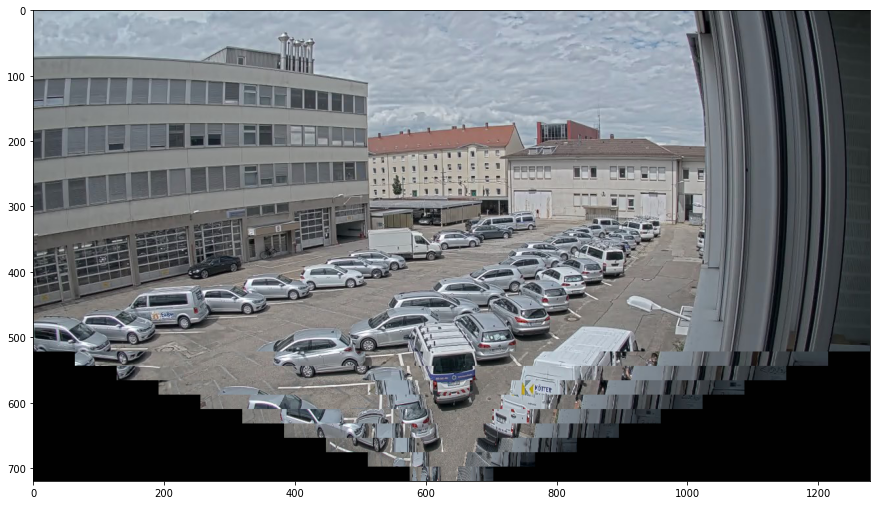

In [29]:
show(w_img)

In [8]:
def dewarp(w_img, s, values):
    'Dewarp `w_img` to its original form in the best way possible.'
    w = w_img.shape[1]
    t_img = w_img[:s]
    for v in values:
        v = cv2.resize(v, (w, v.shape[0]), cv2.INTER_CUBIC)
        t_img = np.vstack([t_img, v])
    return t_img

In [31]:
dw_img = dewarp(w_img, 500, values)

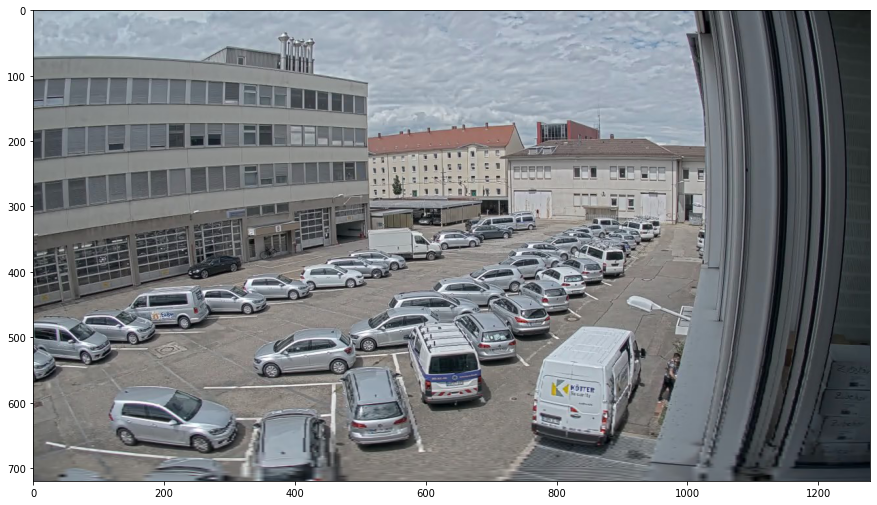

In [32]:
show(dw_img)

dewarp(warp(image)) --> 100 FPS

In [30]:
%%timeit -n 100
w_img, s, values = warp(img, 600, 10)
dw_img = dewarp(w_img, 600, values)

100 loops, best of 3: 10.1 ms per loop


# Apply the warping to a directory

In [9]:
IMG_DIR = '/home/sharif/Downloads/4k'
WAR_DIR = '/home/sharif/Downloads/4k_warped'

Wow, this dirly library is awesome ;) https://github.com/SharifElfouly/dirly

In [13]:
def transform(_f):
    img              = np.array(Image.open(_f))
    w_img, s, values = warp(img, 300, 10)
    dw_img           = dewarp(w_img, 300, values)
    return dw_img

In [14]:
from pathlib import Path
for f in Path(IMG_DIR).iterdir():
    img = transform(f)
    img = Image.fromarray(img)
    img.save(Path(WAR_DIR)/f.name)